# Improved Name Generator

We follow the video linked below and make slight alterations for the convience of a diference in format
>https://www.youtube.com/watch?v=TCH_1BHY58I

Our goal in this notebook is to out line the creation of an improved name generator that is more flexible than the one made in the prior notebook. We wish to have flexibility in how much information (the size of the n-gram) is fed in without exploding the storage. In the last note book, one may have realized that in making a trigram models we used tensors of size 27 x27 x27. For any n-gram model, using the previous format, we would require tensors of size 27^n. This quickly becomes too large for a computer to handle. Instead, we are going to use methods of collapsing the data into lower dimensions. We start this project exactly the same as the prior model - by importing our APIs, names, and creating functions between integers and the alphabet.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

We now create a function that allows or us to build our learning set. We convert our list of words into n-graphs of size block_size. We create a correspondence between the n-1 characters and the nth character where X stores the n-1 character and Y stores the resulting characters. 

In [4]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return(X,Y)

Now, we wish to avoid having our model "memorize" the training set. If we have enough neurons in the network, then we risk overfitting, where the odds of producing anything new or generative becomes near 0. To avoid this, we split up our set of names. We train the network on 80% of the names and make sure the fit is good with another 10% of the names. Doing it this ways makes sure that it isnt simply regurgitating the 80% it was trained on.

In [5]:
random.shuffle(words) #random order of names
n1 = int(.8 * len(words)) #marker of where 80% of names end
n2 = int(.9*len(words)) #marker of where 90% end
block_size = 3 #size of n-grams

Xtr, Ytr = build_dataset(words[:n1], block_size) #taking first 80%
Xval, Yval = build_dataset(words[n1:n2], block_size) #taking next 10%
Xtst, Ytst = build_dataset(words[n2:], block_size) #final 10%

## Structure of Network

We first want to embed our set of inputs of into a matrix of size $27 \times dim$. This embedding will result in a tensor of $N \times n \times dim$ where N is the number of n-grams in our training set and n is the n-gram size. We then want to collapse this tensor back to being a 2d matrix of size $N \times n\cdot dim$. Doing this allows us to use standard matrix multiplication in our linear steps. 

Recall that matrix multiplication turns matrices into linear functions. Thus, we can view our weight matrix as a function from our input layer into our hidden layer. Thus our weight matrix must be a function $\mathbb{R}^{n\cdot dim} \rightarrow \mathbb{R}^{m}$ where $m$ is the number of hidden layers. We then use the affine function of matrix addition. Through broadcasting our biases only need to be of size $m$. Finally, we want to take our hidden layer and output probability of characters. Thus, we want our weight matrix to be a function $\mathbb{R}^{m} \rightarrow \mathbb{R}^{27}$. We finish by adding biases.

In [6]:
hiddenlayersize = 200 #this is our m in the paragraph above
dimension = 10 #this is dim in the paragraph above
C = torch.randn((27,dimension),  requires_grad = True) #for embedding
W1 = torch.randn((block_size*dimension, hiddenlayersize), requires_grad = True) #first weight function
b1 = torch.randn((1,hiddenlayersize),  requires_grad = True) #first bias function
W2 = torch.randn((hiddenlayersize, 27),  requires_grad = True) #second weight function
b2 = torch.randn((27),  requires_grad = True) #second bias function
Paramaters = [C, W1, b1, W2, b2] #list of all parameters

In [7]:
emb = C[Xtr] #our embedding process

In [8]:
layer1 = emb.view(emb.shape[0], block_size*dimension) @ W1+b1 #collapse matrix and apply weight function and bias function
h= torch.tanh(layer1) #hidden layer function

In [9]:
layer2 = (h @W2+b2) #apply second weight function and bias function
loss =  F.cross_entropy(layer2, Ytr)

This loss function is infact the same as our prior loss functions but it is quicker. Part of the reason is the function it calls is written in C++ another part is how well it calculates derivatives. 

As a reminder, the loss function is the $\frac{\sum_{i = 0}^n (\log(p_i))}{n+1}$ where $p_i$ is the probability of out put $Y_i$ given input $X_i$.

Our initial lost is going to be extremely high given we have many parameters initialized randomly with no training

In [10]:
loss

tensor(25.6367, grad_fn=<NllLossBackward0>)

We now remind the reader of the standard process of training our parameters. This is a process that has been seen in the prior two notebooks

In [11]:
for p in Paramaters:
    p.grad = None #set all partial derivatives to 0

In [12]:
loss.backward(retain_graph = True) #back propogate partial derivatives

In [13]:
for p in Paramaters:
    p.data -= .1*p.grad #adjust  parameters by subtracting some small multiple of the partial derivative

In [14]:
emb = C[Xtr] #reinitialize the embedding and run network again
layer1 = emb.view(emb.shape[0], block_size*dimension) @ W1+b1
h= torch.tanh(layer1)
layer2 =(h @W2+b2) 
loss = F.cross_entropy(layer2, Ytr)

In [15]:
loss

tensor(24.0903, grad_fn=<NllLossBackward0>)

We run through this process once more to show how the rate of change of loss is decreasing. Each successive runs lowers the loss by a lower ammount. i.e. the second derivative is positive while our first derivative is negative.

In [16]:
for p in Paramaters:
    p.grad = None

In [17]:
loss.backward(retain_graph = True)

In [18]:
for p in Paramaters:
    p.data -= .1*p.grad

In [19]:
h= torch.tanh(emb.view(emb.shape[0], block_size*dimension) @ W1+b1)
loss = F.cross_entropy((h@W2+b2),Ytr)

In [20]:
loss

tensor(23.2301, grad_fn=<NllLossBackward0>)

Now we want to talk about how to scale this process such that we can minimize our loss quickly without too much overhead. The first problem we need to tackle is discovering a good learning rate. Picking a poor learning rate can mean that we have to run the loop more than otherwise needed - slowing down the entire process.

In [21]:
#Learning rate searching
runs = 1000
lre = torch.linspace(-3,0, runs)
lr = 10**lre

Before we run the entire loop, note if we consider everysingle input, we have thousands upon thousands of calculations to do every run. This takes a long time, instead we want to randomly sample different inputs and lower the loss that way. This will quicken the process of lowering the loss by a sizeable amount.

In [22]:
lri = []
lossi = []
for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (128,))

    #forward pass
    emb = C[Xtr[ix]]
    h= torch.tanh(emb.view(emb.shape[0], block_size*dimension) @ W1+b1)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])

    #backward pass
    for p in Paramaters:
        p.grad = None
    loss.backward()
    learning = lr[k]
    for p in Paramaters:
        p.data -= learning*p.grad

    #track for optimization
    lri.append(lre[k])
    lossi.append(loss.item())

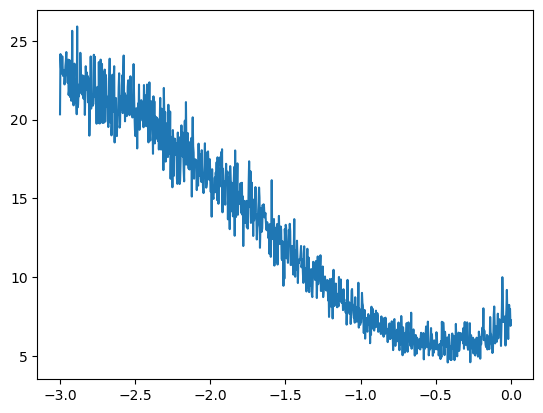

In [23]:
plt.plot(lri, lossi)

Notice our optimal learning rate is occuring close to $10^{-1/2}$. So we will choose that to be our starting learning rate and slowly decay the learning rate as we make more and more runs. We now run the model at large and track our loss with each step.

In [24]:
runs = 60000

In [25]:
lossi = []
stepi = []

for k in range(runs):
    #takes too long to run through all 20k, so we 'minibatch'
    ix = torch.randint(0,Xtr.shape[0], (128,))

    #forward pass
    emb = C[Xtr[ix]]
    h= torch.tanh(emb.view(emb.shape[0], block_size*dimension) @ W1+b1)
    loss = F.cross_entropy((h@W2+b2),Ytr[ix])

    #backward pass
    for p in Paramaters:
        p.grad = None
    loss.backward()
    lr = .316 - .316*k/runs
    for p in Paramaters:
        p.data -= lr*p.grad

    #track for optimization
    lossi.append(loss.log10().item())
    stepi.append(k)

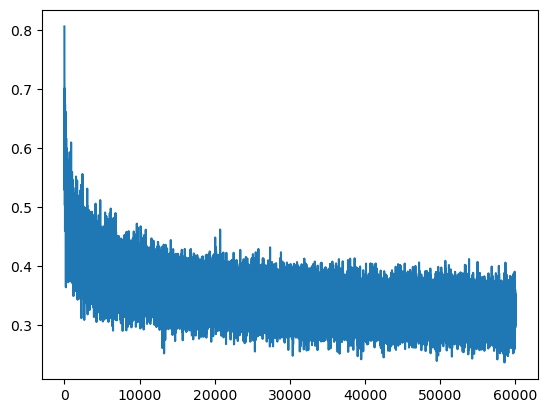

In [26]:
plt.plot(stepi, lossi)

Notice that although Loss stabalizes, it still has quite a bit of noise. This is due to the random sampling taking place. However, even the noise will get thinner upon more runs and the total loss is still being minimized. The model does perform better with 200,000 runs than 20,000 even though the loss only decrease by about .1 in those additional 180,000 runs. 

We now observe the loss on some of the data note used for training and compare it with the loss for training.

In [27]:
emb = C[Xval]
h= torch.tanh(emb.view(emb.shape[0], block_size*dimension) @ W1+b1)
loss = F.cross_entropy((h@W2+b2),Yval)
loss

tensor(2.1548, grad_fn=<NllLossBackward0>)

In [28]:
emb = C[Xtr]
h= torch.tanh(emb.view(emb.shape[0], block_size*dimension) @ W1+b1)
loss = F.cross_entropy((h@W2+b2),Ytr)
loss

tensor(2.1030, grad_fn=<NllLossBackward0>)

Notice that the losses are relatively closs, however the loss will almost always be less on the training set than the valuating set. 

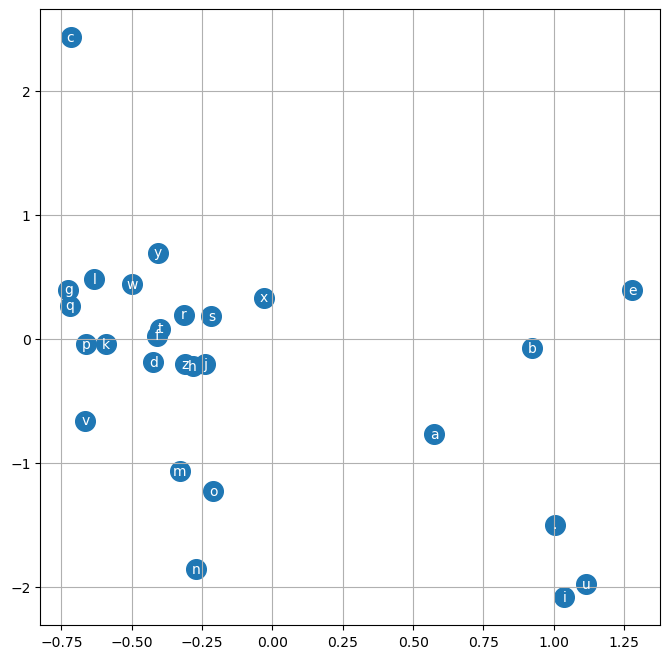

In [29]:
plt.figure(figsize =(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item() , itos[i], ha = "center", va = "center", color = 'white')
plt.grid('minor')

The above figure represents how intechangable the model represents each letter. That is, how close of a role do each letter play. This is important because your model may have zero examples of zo occuring in the n-grams. But z is relatively close to h according the model, so it can look at the probability of letters following he in order to train ze. (Note, this graph is not nearly close to perfect is there are actually another 8 dimensions not shown here. One thing we could do to combat this is take the standard inner produt of two characters and use that to measure distance and organize this in a data. However, this is exapansion for another day.) 

We now generate 20 example names. The code for generating names is almost exactly how we have been doing it in the past

In [30]:
for i in range(20):
    out = ''
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h= torch.tanh(emb.view(emb.shape[0], -1) @ W1+b1)
        probs = F.softmax(h@W2+b2, dim = 1)
        ix = torch.multinomial(probs, num_samples =1 ).item()
        context = context[1:]+[ix]
        if ix ==0:
            break
        out += itos[ix]
    print(out)

jorne
mani
jorn
yardan
amie
vaneve
willaharier
kriston
azramari
dechntelesteva
aysen
reya
chin
hlani
ahlani
ava
loreah
gell
ganie
malitolly
